In [1]:
import missingno as mn
import numpy as np
import pandas as pd
from sklearn.base import TransformerMixin
from pycaret.classification import (
    setup,
    compare_models,
    plot_model,
    create_model,
    tune_model,
    predict_model,
    stack_models,
    save_model,
    load_model,
)
import imblearn
from pycaret.classification import *

In [2]:
df =  pd.read_csv("covid_with_NA.csv")
df['temperature.over38'] = df['temperature.over38'].astype(float).astype(object)
df['pulseOx.under90'] = df['pulseOx.under90'].astype(float).astype(object)
df['Respiration.over24'] = df['Respiration.over24'].astype(float).astype(object)

<AxesSubplot:>

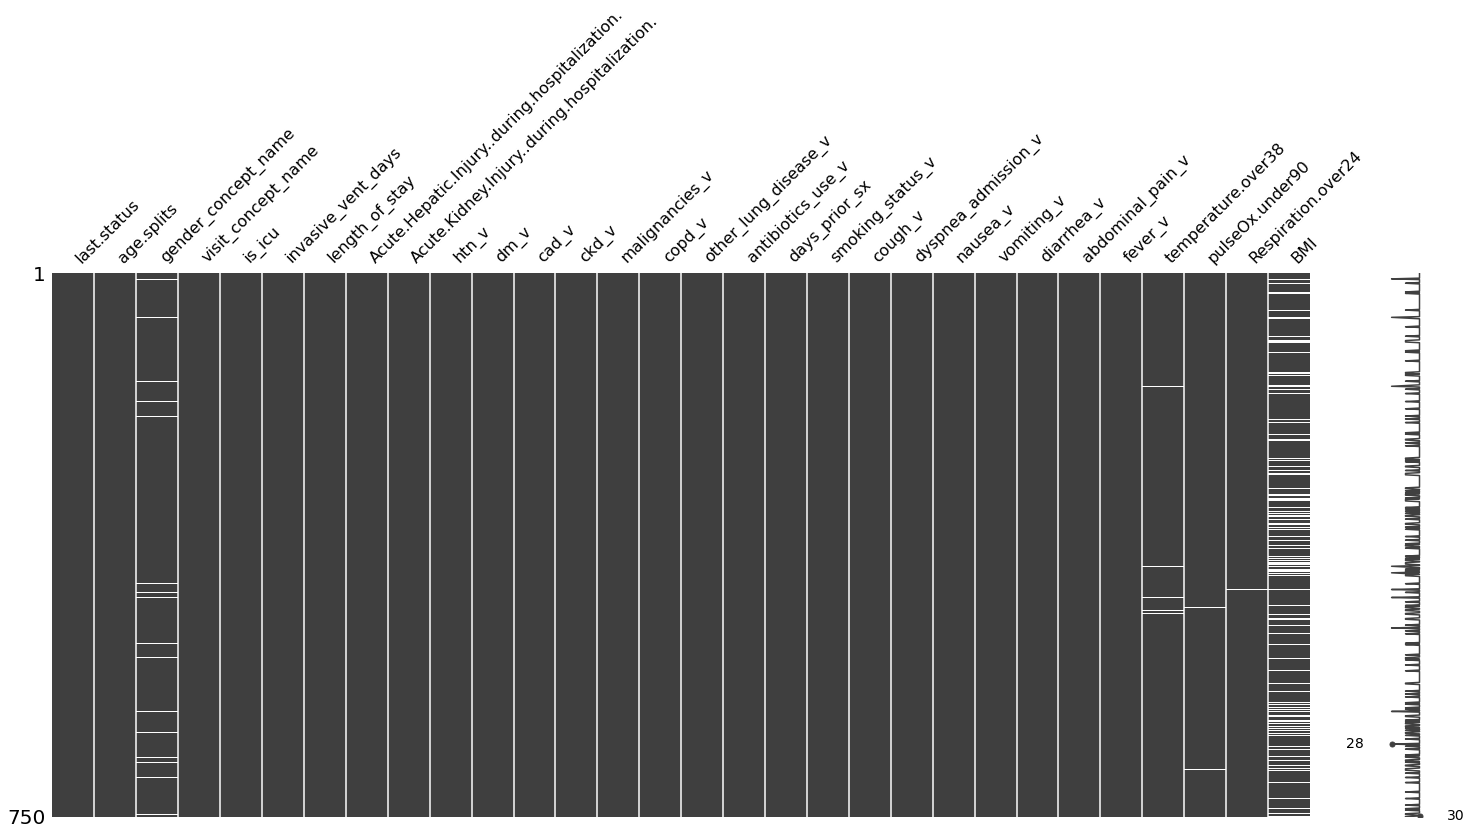

In [3]:
mn.matrix(df.drop(['Unnamed: 0','to_patient_id'],axis = 1))

In [4]:
df.select_dtypes('object').isnull().sum()

to_patient_id                                      0
last.status                                        0
age.splits                                         0
gender_concept_name                               19
visit_concept_name                                 0
Acute.Hepatic.Injury..during.hospitalization.      0
Acute.Kidney.Injury..during.hospitalization.       0
htn_v                                              0
dm_v                                               0
cad_v                                              0
ckd_v                                              0
malignancies_v                                     0
copd_v                                             0
other_lung_disease_v                               0
antibiotics_use_v                                  0
smoking_status_v                                   0
cough_v                                            0
dyspnea_admission_v                                0
nausea_v                                      

In [5]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index = X.columns)

        return self

    def transform(self, X, y = None):
        return X.fillna(self.fill)

In [6]:
df_imputed = DataFrameImputer().fit_transform(df)
df_imputed['temperature.over38'] = df_imputed['temperature.over38'].astype(float).astype(object)
df_imputed['pulseOx.under90'] = df_imputed['pulseOx.under90'].astype(float).astype(object)
df_imputed['Respiration.over24'] = df_imputed['Respiration.over24'].astype(float).astype(object)

In [7]:
df_X_im = df_imputed.drop(['Unnamed: 0', 'to_patient_id', 'last.status'], axis = 1)
df_Y_im = df_imputed[['last.status']]

In [8]:
df_X_dummy = pd.get_dummies(df_X_im)

In [9]:
df_X_im_resampled, df_Y_im_resampled = \
imblearn.over_sampling.SMOTE().fit_resample(df_X_dummy, df_Y_im)

In [10]:
df_age = df_X_im_resampled[["age.splits_(59,74]",
                           "age.splits_(74,90]",
                           "age.splits_[18,59]"]]
df_age = df_age.idxmax(axis = 1)
age = df_age.str.split('_').str[1]

In [11]:
df_gender = df_X_im_resampled[["gender_concept_name_FEMALE",
                               "gender_concept_name_MALE"]]
df_gender = df_gender.idxmax(axis = 1)
gender = df_gender.str.split('_').str[3]

In [12]:
df_visit = df_X_im_resampled[["visit_concept_name_Emergency Room Visit",
                              "visit_concept_name_Inpatient Visit"]]
df_visit = df_visit.idxmax(axis = 1)
visit = df_visit.str.split('_').str[3]

In [13]:
df_acute_hep = df_X_im_resampled[["Acute.Hepatic.Injury..during.hospitalization._No",
                                  "Acute.Hepatic.Injury..during.hospitalization._Yes"]]
df_acute_hep = df_acute_hep.idxmax(axis = 1)
acute_hep = df_acute_hep.str.split('_').str[1]

In [14]:
df_acute_kid = df_X_im_resampled[["Acute.Kidney.Injury..during.hospitalization._No",
                                  "Acute.Kidney.Injury..during.hospitalization._Yes"]]
df_acute_kid = df_acute_kid.idxmax(axis = 1)
acute_kid = df_acute_kid.str.split('_').str[1]

In [15]:
df_htn = df_X_im_resampled[["htn_v_No",
                            "htn_v_Yes"]]
df_htn = df_htn.idxmax(axis = 1)
htn = df_htn.str.split('_').str[2]

In [16]:
df_dm = df_X_im_resampled[["dm_v_No",
                           "dm_v_Yes"]]
df_dm = df_dm.idxmax(axis = 1)
dm = df_dm.str.split('_').str[2]

In [17]:
df_cad = df_X_im_resampled[["cad_v_No",
                           "cad_v_Yes"]]
df_cad = df_cad.idxmax(axis = 1)
cad = df_cad.str.split('_').str[2]

In [18]:
df_ckd = df_X_im_resampled[["ckd_v_No",
                           "ckd_v_Yes"]]
df_ckd = df_ckd.idxmax(axis = 1)
ckd = df_ckd.str.split('_').str[2]

In [19]:
df_malign = df_X_im_resampled[["malignancies_v_No",
                           "malignancies_v_Yes"]]
df_malign = df_malign.idxmax(axis = 1)
malign = df_malign.str.split('_').str[2]

In [20]:
df_copd = df_X_im_resampled[["copd_v_No",
                           "copd_v_Yes"]]
df_copd = df_copd.idxmax(axis = 1)
copd = df_copd.str.split('_').str[2]

In [21]:
df_other_lung = df_X_im_resampled[["other_lung_disease_v_No",
                           "other_lung_disease_v_Yes"]]
df_other_lung = df_other_lung.idxmax(axis = 1)
other_lung = df_other_lung.str.split('_').str[4]

In [22]:
df_anti = df_X_im_resampled[["antibiotics_use_v_No",
                           "antibiotics_use_v_Yes"]]
df_anti = df_anti.idxmax(axis = 1)
anti = df_anti.str.split('_').str[3]

In [23]:
df_smoking = df_X_im_resampled[["smoking_status_v_Current",
                                "smoking_status_v_Former",
                                "smoking_status_v_Never"]]
df_smoking = df_smoking.idxmax(axis = 1)
smoking = df_smoking.str.split('_').str[3]

In [24]:
df_cough = df_X_im_resampled[["cough_v_No",
                              "cough_v_Yes"]]
df_cough = df_cough.idxmax(axis = 1)
cough = df_cough.str.split('_').str[2]

In [25]:
df_dyspnea = df_X_im_resampled[["dyspnea_admission_v_No",
                              "dyspnea_admission_v_Yes"]]
df_dyspnea = df_dyspnea.idxmax(axis = 1)
dyspnea = df_dyspnea.str.split('_').str[3]

In [26]:
df_nausea = df_X_im_resampled[["nausea_v_No",
                              "nausea_v_Yes"]]
df_nausea = df_nausea.idxmax(axis = 1)
nausea = df_nausea.str.split('_').str[2]

In [27]:
df_vomit = df_X_im_resampled[["vomiting_v_No",
                              "vomiting_v_Yes"]]
df_vomit = df_vomit.idxmax(axis = 1)
vomit = df_vomit.str.split('_').str[2]

In [28]:
df_diarrhea = df_X_im_resampled[["diarrhea_v_No",
                              "diarrhea_v_Yes"]]
df_diarrhea = df_diarrhea.idxmax(axis = 1)
diarrhea = df_diarrhea.str.split('_').str[2]

In [29]:
df_pain = df_X_im_resampled[["abdominal_pain_v_No",
                                 "abdominal_pain_v_Yes"]]
df_pain = df_pain.idxmax(axis = 1)
pain = df_pain.str.split('_').str[3]

In [30]:
df_fever = df_X_im_resampled[["fever_v_No",
                              "fever_v_Yes"]]
df_fever = df_fever.idxmax(axis = 1)
fever = df_fever.str.split('_').str[2]

In [31]:
df_temp = df_X_im_resampled[["temperature.over38_0.0",
                              "temperature.over38_1.0"]]
df_temp = df_temp.idxmax(axis = 1)
temp = df_temp.str.split('_').str[1]

In [32]:
df_pulseOx = df_X_im_resampled[["pulseOx.under90_0.0",
                             "pulseOx.under90_1.0"]]
df_pulseOx = df_pulseOx.idxmax(axis = 1)
pulseOx = df_pulseOx.str.split('_').str[1]

In [33]:
df_resp = df_X_im_resampled[["Respiration.over24_0.0",
                             "Respiration.over24_1.0"]]
df_resp = df_resp.idxmax(axis = 1)
resp = df_resp.str.split('_').str[1]

In [34]:
df_bmi = df_X_im_resampled[["BMI_Above 35",
                             "BMI_Between 30 and 35",
                            "BMI_Under 30"]]
df_bmi = df_bmi.idxmax(axis = 1)
bmi = df_bmi.str.split('_').str[1]

In [35]:
x_input = {
    "is.icu": df_X_im_resampled["is_icu"],
    "invasive_vent_days": df_X_im_resampled["invasive_vent_days"],
    "length_of_stay": df_X_im_resampled["length_of_stay"],
    "days_prior_sx": df_X_im_resampled["days_prior_sx"],
    "age.splits": age,
    "gender_concept_name": gender,
    "visit_concept_name": visit,
    "Acute.Hepatic.Injury..during.hospitalization.": acute_hep,
    "Acute.Kidney.Injury..during.hospitalization.": acute_kid,
    "htn_v": htn,
    "dm_v": dm,
    "cad_v": cad,
    "ckd_v": ckd,
    "malignancies_v": malign,
    "copd_v": copd,
    "other_lung_disease_v": other_lung,
    "antibiotics_use_v": anti,
    "smoking_status_v": smoking,
    "cough_v": cough,
    "dyspnea_admission_v": dyspnea,
    "nausea_v": nausea,
    "vomiting_v": vomit,
    "diarrhea_v": diarrhea,
    "abdominal_pain_v": pain,
    "fever_v": fever,
    "temperature.over38": temp,
    "pulseOx.under90": pulseOx,
    "Respiration.over24": resp,
    "BMI": bmi
}
df_X_db = pd.DataFrame(x_input)

In [36]:
def compare_model(dataset):
    '''Building the models based on the input dataset'''
    clfs = setup(data = df_im_fit,
             target = "last.status",
             silent = True,
             session_id = 1)
    best_model = compare_models(sort = "Accuracy")
    best_results = pull()
    return best_results

In [37]:
# creating the imputed dataset
df_im_fit = pd.concat([df_Y_im,
                     df_X_im], axis=1)
df_im_fit

,last.status,age.splits,gender_concept_name,visit_concept_name,is_icu,invasive_vent_days,length_of_stay,Acute.Hepatic.Injury..during.hospitalization.,Acute.Kidney.Injury..during.hospitalization.,htn_v,...,dyspnea_admission_v,nausea_v,vomiting_v,diarrhea_v,abdominal_pain_v,fever_v,temperature.over38,pulseOx.under90,Respiration.over24,BMI
0,discharged,"(59,74]",FEMALE,Inpatient Visit,False,0,8,No,No,No,...,Yes,Yes,No,Yes,No,Yes,0,0,0,Under 30
1,discharged,"(59,74]",MALE,Inpatient Visit,False,0,11,No,No,Yes,...,Yes,No,No,No,No,No,0,0,1,Under 30
2,deceased,"(74,90]",MALE,Inpatient Visit,True,16,23,No,Yes,Yes,...,Yes,No,No,No,No,Yes,0,0,1,Under 30
3,discharged,"[18,59]",FEMALE,Inpatient Visit,False,0,10,No,No,No,...,No,No,No,No,No,Yes,0,0,0,Under 30
4,discharged,"[18,59]",MALE,Emergency Room Visit,False,0,1,No,No,No,...,Yes,No,No,No,No,No,0,0,0,Under 30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,discharged,"(59,74]",FEMALE,Inpatient Visit,False,0,5,No,No,No,...,Yes,No,No,Yes,No,No,0,0,1,Under 30
746,deceased,"[18,59]",MALE,Inpatient Visit,True,34,48,Yes,Yes,No,...,Yes,No,No,No,No,Yes,0,1,1,Above 35
747,deceased,"(59,74]",FEMALE,Inpatient Visit,True,21,38,Yes,Yes,No,...,Yes,No,No,No,No,Yes,0,1,1,Above 35
748,discharged,"[18,59]",MALE,Inpatient Visit,False,0,14,No,No,No,...,Yes,No,No,No,No,Yes,1,1,0,Under 30


In [38]:
# writing the dataframe to csv file
df_im_fit.to_csv("imputed_dataset.csv")

In [39]:
best_impute = compare_model(df_im_fit)
best_impute

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Logistic Regression,0.9390,0.9431,0.9804,0.9526,0.9657,0.6822,0.7054,0.0463
1,Light Gradient Boosting Machine,0.9295,0.9229,0.9739,0.9473,0.9600,0.6548,0.6730,0.0656
2,Ridge Classifier,0.9275,0.0000,0.9716,0.9474,0.9590,0.6418,0.6573,0.0099
3,Linear Discriminant Analysis,0.9217,0.9369,0.9499,0.9609,0.9546,0.6624,0.6748,0.0217
4,Extra Trees Classifier,0.9181,0.9217,0.9673,0.9410,0.9533,0.6074,0.6290,0.2573
5,K Neighbors Classifier,0.9180,0.8246,0.9846,0.9265,0.9546,0.5320,0.5549,0.0064
6,CatBoost Classifier,0.9180,0.9373,0.9760,0.9333,0.9540,0.5751,0.5956,1.7552
7,Extreme Gradient Boosting,0.9142,0.9327,0.9586,0.9446,0.9511,0.5929,0.6039,0.1397
8,Gradient Boosting Classifier,0.9141,0.9349,0.9629,0.9407,0.9513,0.5828,0.5941,0.1536
9,Ada Boost Classifier,0.9124,0.9157,0.9629,0.9388,0.9504,0.5698,0.5826,0.1634


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Logistic Regression,0.9390,0.9431,0.9804,0.9526,0.9657,0.6822,0.7054,0.0463
1,Light Gradient Boosting Machine,0.9295,0.9229,0.9739,0.9473,0.9600,0.6548,0.6730,0.0656
2,Ridge Classifier,0.9275,0.0000,0.9716,0.9474,0.9590,0.6418,0.6573,0.0099
3,Linear Discriminant Analysis,0.9217,0.9369,0.9499,0.9609,0.9546,0.6624,0.6748,0.0217
4,Extra Trees Classifier,0.9181,0.9217,0.9673,0.9410,0.9533,0.6074,0.6290,0.2573
5,K Neighbors Classifier,0.9180,0.8246,0.9846,0.9265,0.9546,0.5320,0.5549,0.0064
6,CatBoost Classifier,0.9180,0.9373,0.9760,0.9333,0.9540,0.5751,0.5956,1.7552
7,Extreme Gradient Boosting,0.9142,0.9327,0.9586,0.9446,0.9511,0.5929,0.6039,0.1397
8,Gradient Boosting Classifier,0.9141,0.9349,0.9629,0.9407,0.9513,0.5828,0.5941,0.1536
9,Ada Boost Classifier,0.9124,0.9157,0.9629,0.9388,0.9504,0.5698,0.5826,0.1634


In [40]:
# writing the dataframe to csv file
best_impute.to_csv("imputed_results.csv")

In [41]:
# creating the imputed and over-sampling dataset
df_db_fit = pd.concat([df_Y_im_resampled,
                     df_X_db], axis = 1)
df_db_fit

,last.status,is.icu,invasive_vent_days,length_of_stay,days_prior_sx,age.splits,gender_concept_name,visit_concept_name,Acute.Hepatic.Injury..during.hospitalization.,Acute.Kidney.Injury..during.hospitalization.,...,dyspnea_admission_v,nausea_v,vomiting_v,diarrhea_v,abdominal_pain_v,fever_v,temperature.over38,pulseOx.under90,Respiration.over24,BMI
0,discharged,False,0,8,4,"(59,74]",FEMALE,Inpatient Visit,No,No,...,Yes,Yes,No,Yes,No,Yes,0.0,0.0,0.0,Under 30
1,discharged,False,0,11,10,"(59,74]",MALE,Inpatient Visit,No,No,...,Yes,No,No,No,No,No,0.0,0.0,1.0,Under 30
2,deceased,True,16,23,7,"(74,90]",MALE,Inpatient Visit,No,Yes,...,Yes,No,No,No,No,Yes,0.0,0.0,1.0,Under 30
3,discharged,False,0,10,1,"[18,59]",FEMALE,Inpatient Visit,No,No,...,No,No,No,No,No,Yes,0.0,0.0,0.0,Under 30
4,discharged,False,0,1,1,"[18,59]",MALE,Emergency Room Visit,No,No,...,Yes,No,No,No,No,No,0.0,0.0,0.0,Under 30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,deceased,True,9,13,7,"(59,74]",MALE,Inpatient Visit,No,Yes,...,Yes,No,No,No,No,Yes,0.0,1.0,1.0,Above 35
1306,deceased,True,10,14,10,"(59,74]",MALE,Inpatient Visit,No,Yes,...,No,No,No,No,No,Yes,0.0,0.0,0.0,Under 30
1307,deceased,True,27,32,8,"(59,74]",MALE,Inpatient Visit,No,No,...,Yes,No,No,No,No,Yes,0.0,0.0,0.0,Under 30
1308,deceased,True,13,14,4,"(59,74]",MALE,Inpatient Visit,No,Yes,...,No,No,No,No,No,No,0.0,0.0,0.0,Under 30


In [42]:
# writing the dataframe to csv file
df_db_fit.to_csv("db_dataset.csv")

In [43]:
best_db = compare_model(df_db_fit)
best_db

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Logistic Regression,0.9390,0.9431,0.9804,0.9526,0.9657,0.6822,0.7054,0.0508
1,Light Gradient Boosting Machine,0.9295,0.9229,0.9739,0.9473,0.9600,0.6548,0.6730,0.0620
2,Ridge Classifier,0.9275,0.0000,0.9716,0.9474,0.9590,0.6418,0.6573,0.0074
3,Linear Discriminant Analysis,0.9217,0.9369,0.9499,0.9609,0.9546,0.6624,0.6748,0.0105
4,Extra Trees Classifier,0.9181,0.9217,0.9673,0.9410,0.9533,0.6074,0.6290,0.2567
5,K Neighbors Classifier,0.9180,0.8246,0.9846,0.9265,0.9546,0.5320,0.5549,0.0064
6,CatBoost Classifier,0.9180,0.9373,0.9760,0.9333,0.9540,0.5751,0.5956,1.5471
7,Extreme Gradient Boosting,0.9142,0.9327,0.9586,0.9446,0.9511,0.5929,0.6039,0.1313
8,Gradient Boosting Classifier,0.9141,0.9349,0.9629,0.9407,0.9513,0.5828,0.5941,0.1540
9,Ada Boost Classifier,0.9124,0.9157,0.9629,0.9388,0.9504,0.5698,0.5826,0.1631


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Logistic Regression,0.9390,0.9431,0.9804,0.9526,0.9657,0.6822,0.7054,0.0508
1,Light Gradient Boosting Machine,0.9295,0.9229,0.9739,0.9473,0.9600,0.6548,0.6730,0.0620
2,Ridge Classifier,0.9275,0.0000,0.9716,0.9474,0.9590,0.6418,0.6573,0.0074
3,Linear Discriminant Analysis,0.9217,0.9369,0.9499,0.9609,0.9546,0.6624,0.6748,0.0105
4,Extra Trees Classifier,0.9181,0.9217,0.9673,0.9410,0.9533,0.6074,0.6290,0.2567
5,K Neighbors Classifier,0.9180,0.8246,0.9846,0.9265,0.9546,0.5320,0.5549,0.0064
6,CatBoost Classifier,0.9180,0.9373,0.9760,0.9333,0.9540,0.5751,0.5956,1.5471
7,Extreme Gradient Boosting,0.9142,0.9327,0.9586,0.9446,0.9511,0.5929,0.6039,0.1313
8,Gradient Boosting Classifier,0.9141,0.9349,0.9629,0.9407,0.9513,0.5828,0.5941,0.1540
9,Ada Boost Classifier,0.9124,0.9157,0.9629,0.9388,0.9504,0.5698,0.5826,0.1631


In [44]:
# writing the dataframe to csv file
best_db.to_csv("imputed_sampling_results.csv")